# Show me everyone from \$X country that has visited \$Y extremist forum

_Inspired by The Guardian's release of the [XKeyscore presentation](http://www.theguardian.com/world/interactive/2013/jul/31/nsa-xkeyscore-program-full-presentation)._

## Tutorial Code

Let's re-import scapy

In [1]:
import logging
logging.getLogger("scapy.runtime").setLevel(logging.ERROR)
from scapy.all import *

And load the pre-sniffed HTTP traffic that I grabbed from [Wireshark's Samples](http://wiki.wireshark.org/SampleCaptures):

In [3]:
sniffed = "../data/http.cap"
pkts = sniff(offline=sniffed)

We can see that we have 41 TCP datagrams (aka packets) and 2 UDP datagrams:

In [4]:
pkts

<Sniffed: TCP:41 UDP:2 ICMP:0 Other:0>

Let's see that nice summary like last time using `nsummary`:

In [5]:
pkts.nsummary()

0000 Ether / IP / TCP 145.254.160.237:tip2 > 65.208.228.223:http S
0001 Ether / IP / TCP 65.208.228.223:http > 145.254.160.237:tip2 SA
0002 Ether / IP / TCP 145.254.160.237:tip2 > 65.208.228.223:http A
0003 Ether / IP / TCP 145.254.160.237:tip2 > 65.208.228.223:http PA / Raw
0004 Ether / IP / TCP 65.208.228.223:http > 145.254.160.237:tip2 A
0005 Ether / IP / TCP 65.208.228.223:http > 145.254.160.237:tip2 A / Raw
0006 Ether / IP / TCP 145.254.160.237:tip2 > 65.208.228.223:http A
0007 Ether / IP / TCP 65.208.228.223:http > 145.254.160.237:tip2 A / Raw
0008 Ether / IP / TCP 145.254.160.237:tip2 > 65.208.228.223:http A
0009 Ether / IP / TCP 65.208.228.223:http > 145.254.160.237:tip2 A / Raw
0010 Ether / IP / TCP 65.208.228.223:http > 145.254.160.237:tip2 PA / Raw
0011 Ether / IP / TCP 145.254.160.237:tip2 > 65.208.228.223:http A
0012 Ether / IP / UDP / DNS Qry "pagead2.googlesyndication.com." 
0013 Ether / IP / TCP 65.208.228.223:http > 145.254.160.237:tip2 A / Raw
0014 Ether / IP / TCP 14

And let's pick off the third packet:

In [6]:
pkts[3].show()

###[ Ethernet ]###
  dst       = fe:ff:20:00:01:00
  src       = 00:00:01:00:00:00
  type      = 0x800
###[ IP ]###
     version   = 4L
     ihl       = 5L
     tos       = 0x0
     len       = 519
     id        = 3909
     flags     = DF
     frag      = 0L
     ttl       = 128
     proto     = tcp
     chksum    = 0x9010
     src       = 145.254.160.237
     dst       = 65.208.228.223
     \options   \
###[ TCP ]###
        sport     = tip2
        dport     = http
        seq       = 951057940
        ack       = 290218380
        dataofs   = 5L
        reserved  = 0L
        flags     = PA
        window    = 9660
        chksum    = 0xa958
        urgptr    = 0
        options   = []
###[ Raw ]###
           load      = 'GET /download.html HTTP/1.1\r\nHost: www.ethereal.com\r\nUser-Agent: Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.6) Gecko/20040113\r\nAccept: text/xml,application/xml,application/xhtml+xml,text/html;q=0.9,text/plain;q=0.8,image/png,image/jpeg,image/gif;q

and parse out the actual payload of it:

In [7]:
load = pkts[3].getlayer(Raw).fields.get("load")
print load

GET /download.html HTTP/1.1
Host: www.ethereal.com
User-Agent: Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.6) Gecko/20040113
Accept: text/xml,application/xml,application/xhtml+xml,text/html;q=0.9,text/plain;q=0.8,image/png,image/jpeg,image/gif;q=0.2,*/*;q=0.1
Accept-Language: en-us,en;q=0.5
Accept-Encoding: gzip,deflate
Accept-Charset: ISO-8859-1,utf-8;q=0.7,*;q=0.7
Keep-Alive: 300
Connection: keep-alive
Referer: http://www.ethereal.com/development.html




Woah - Windows NT! this packet must be ancient ;)


It's super simple to parse out HTTP header information, and then from there, all we need to do is a simple check of if the "extremist" forum that we're interested in is inside these packets:

In [8]:
'GET /download' in load

True

In [9]:
'www.ethereal.com' in load

True

Now we can play around and traceroute between the user's IP address and the 

In [10]:
import select as s

In [25]:
def trace_route(pkts):
    for pkt in pkts:
        try:
            IP_layer = pkt.getlayer(IP)
            proto_layer = pkt.getlayer(TCP)
        except Exception:
            continue
        destination = IP_layer.dst
        src = IP_layer.src
        dport = proto_layer.dport
        sport = proto_layer.sport
        
        while True:
            try:
                res, unans = traceroute(target=destination, dport=dport, sport=sport, maxttl=20)
                traces = res.res
                hops = [src]
                for trace in traces:
                    hops.append(trace[1].src)
                return res, hops, sport
            except s.error:
                continue


In [26]:
res, tr, sport = trace_route(pkts)


Received 18 packets, got 18 answers, remaining 2 packets
   65.208.228.223:tcp80 
1  192.168.1.1     11   
2  103.6.148.46    11   
3  103.224.165.1   11   
4  103.6.148.45    11   
5  183.182.80.69   11   
6  173.205.57.82   11   
7  141.136.109.21  11   
8  4.69.153.25     11   
9  4.69.132.58     11   
10 4.69.151.182    11   
11 206.222.122.50  11   
12 4.68.71.102     11   
13 4.69.152.190    11   
14 207.250.67.110  11   
15 68.66.15.90     11   
16 4.69.132.62     11   
17 68.66.15.230    11   
18 4.69.203.254    11   
Begin emission:
Finished to send 20 packets.


In [27]:
tr

['145.254.160.237',
 '192.168.1.1',
 '103.6.148.46',
 '103.224.165.1',
 '103.6.148.45',
 '183.182.80.69',
 '173.205.57.82',
 '141.136.109.21',
 '4.69.153.25',
 '4.69.132.58',
 '4.69.151.182',
 '206.222.122.50',
 '4.68.71.102',
 '4.69.152.190',
 '207.250.67.110',
 '68.66.15.90',
 '4.69.132.62',
 '68.66.15.230',
 '4.69.203.254']

In [15]:
import pygeoip

In [17]:
def map_ip(hops):
    gip = pygeoip.GeoIP('../data/GeoLiteCity.dat')
    coordinates = []
    for hop in hops:
        geo_data = gip.record_by_addr(hop)
        if geo_data:
            lat = geo_data['latitude']
            lon = geo_data['longitude']
            coordinates.append((lon, lat))
    return coordinates

In [18]:
coordinates = map_ip(tr)

In [19]:
coordinates

[(9.0, 51.0),
 (103.80000000000001, 1.3667000000000087),
 (103.80000000000001, 1.3667000000000087),
 (114.16669999999999, 22.25),
 (2.3499999999999943, 48.860000000000014),
 (-0.12999999999999545, 51.5),
 (-97.0, 38.0),
 (-97.0, 38.0),
 (-97.0, 38.0),
 (-97.0, 38.0),
 (-94.8902, 38.8853),
 (-97.0, 38.0),
 (-97.0, 38.0),
 (-94.8902, 38.8853),
 (-90.7289, 38.82509999999999)]

In [20]:
import geojson

In [21]:
def create_geojson(coordinates):
    geo_list = []
    j = 1
    for index in xrange(0, len(coordinates)):
        try:
            data = {}
            data["type"] = "Feature"
            data["id"] = j
            data["properties"] = {"title": "hop %i" % j}
            data["geometry"] = {"type": "LineString", "coordinates": [coordinates[index], coordinates[index+1] ]}
            j += 1
            geo_list.append(data)
        except IndexError:
            continue

    d = {"type": "FeatureCollection"}
    for item in geo_list:
        d.setdefault("features", []).append(item)

    return geojson.dumps(d)

In [23]:
data = create_geojson(coordinates)
print data

{"type": "FeatureCollection", "features": [{"geometry": {"type": "LineString", "coordinates": [[9.0, 51.0], [103.80000000000001, 1.3667000000000087]]}, "type": "Feature", "id": 1, "properties": {"title": "hop 1"}}, {"geometry": {"type": "LineString", "coordinates": [[103.80000000000001, 1.3667000000000087], [103.80000000000001, 1.3667000000000087]]}, "type": "Feature", "id": 2, "properties": {"title": "hop 2"}}, {"geometry": {"type": "LineString", "coordinates": [[103.80000000000001, 1.3667000000000087], [114.16669999999999, 22.25]]}, "type": "Feature", "id": 3, "properties": {"title": "hop 3"}}, {"geometry": {"type": "LineString", "coordinates": [[114.16669999999999, 22.25], [2.3499999999999943, 48.860000000000014]]}, "type": "Feature", "id": 4, "properties": {"title": "hop 4"}}, {"geometry": {"type": "LineString", "coordinates": [[2.3499999999999943, 48.860000000000014], [-0.12999999999999545, 51.5]]}, "type": "Feature", "id": 5, "properties": {"title": "hop 5"}}, {"geometry": {"type

Navigate to [geojson.io](http://geojson.io/) in your browser.  Then copy & paste the `data` output into the JSON input area.

Here's mine (copied from the "share" button on geojson.io):

In [24]:
from IPython.display import HTML
HTML('<iframe frameborder="0" width="100%" height="300" src="http://bl.ocks.org/d/7644d2c0dd4662db98ab"></iframe>')

In [28]:
res.graph(target="> ../data/Q2-traceroute.svg")

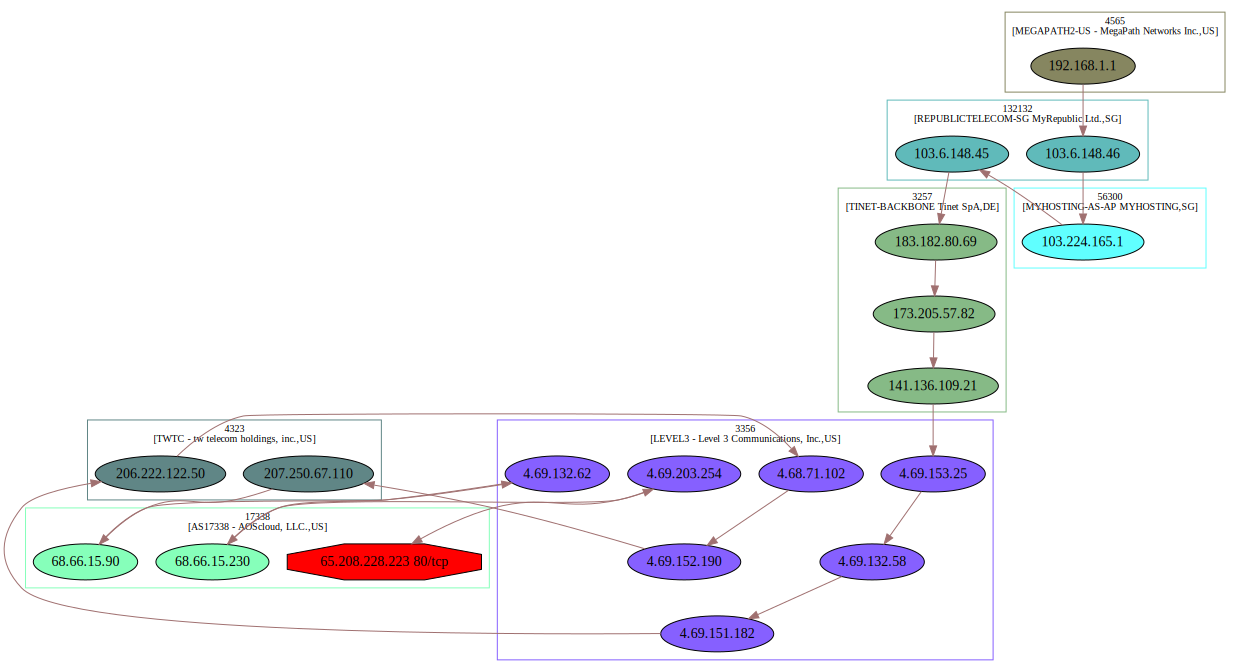

In [29]:
from IPython.display import SVG
svg_file = "../data/Q2-traceroute.svg"
SVG(svg_file)